WIP

In [13]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv")

### Preparation

In [3]:
obesity_df = df[df['Class'] == 'Obesity / Weight Status']
obesity_threshold = obesity_df['Data_Value'].quantile(0.85)
obesity_df = obesity_df[obesity_df['Data_Value'] > obesity_threshold]

physical_activity_df = df[df['Class'] == 'Physical Activity']
physical_activity_threshold = physical_activity_df['Data_Value'].quantile(0.85)
physical_activity_df = physical_activity_df[physical_activity_df['Data_Value'] > physical_activity_threshold]

combined_df = pd.concat([obesity_df, physical_activity_df])

factors = ['Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'LocationDesc']
X = combined_df[factors]

combined_df['Treatment'] = (combined_df['Class'] == 'Obesity / Weight Status').astype(int)
y = combined_df['Data_Value']


### Propensity scores 
probability of being in the "obesity" group

In [4]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, combined_df['Treatment'], test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
combined_df['Propensity_Score'] = log_reg.predict_proba(X_encoded)[:, 1] 

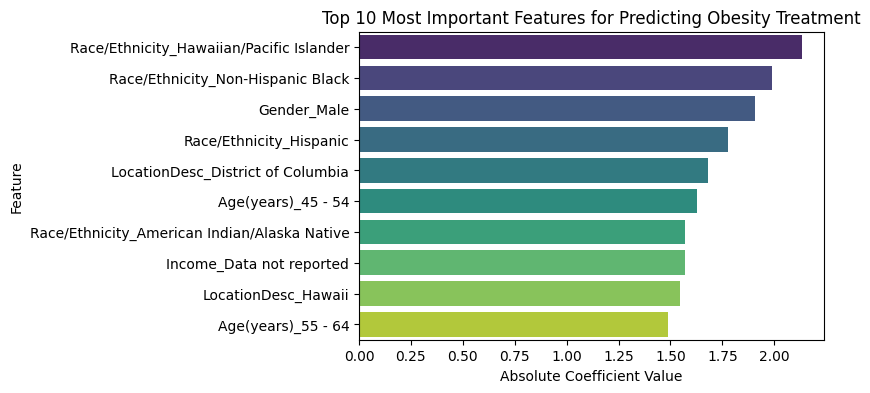

In [12]:
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': log_reg.coef_[0]
})

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
top_features = coefficients.sort_values(by='Abs_Coefficient', ascending=False).head(10)

plt.figure(figsize=(6, 4))
sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Obesity PS')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [14]:
y_pred = log_reg.predict(X_test)

print("PS confusion matrix")
confusion_matrix(y_test, y_pred)

array([[1139,  326],
       [ 518,  554]])

In [15]:
print("PS classification report")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1465
           1       0.63      0.52      0.57      1072

    accuracy                           0.67      2537
   macro avg       0.66      0.65      0.65      2537
weighted avg       0.66      0.67      0.66      2537



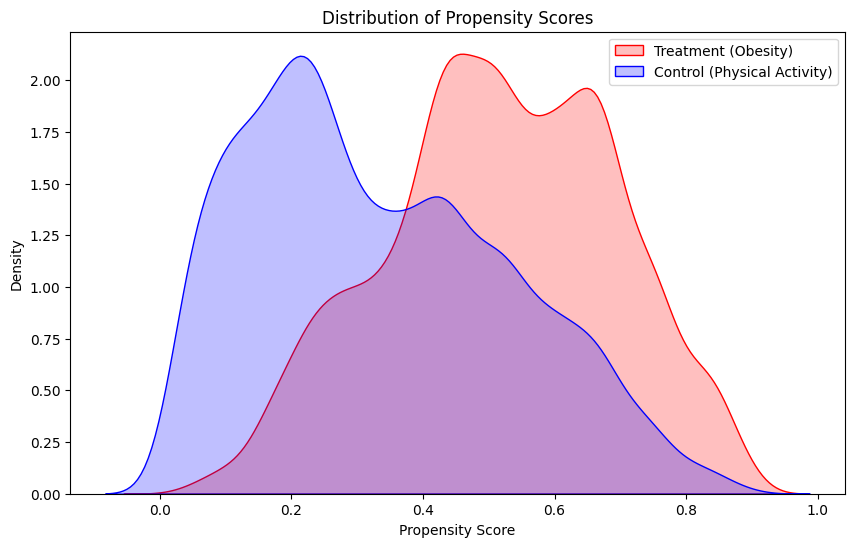

In [5]:
plt.figure(figsize=(10, 6))
sns.kdeplot(combined_df.loc[combined_df['Treatment'] == 1, 'Propensity_Score'], color='red', label='Treatment (Obesity)', shade=True)
sns.kdeplot(combined_df.loc[combined_df['Treatment'] == 0, 'Propensity_Score'], color='blue', label='Control (Physical Activity)', shade=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

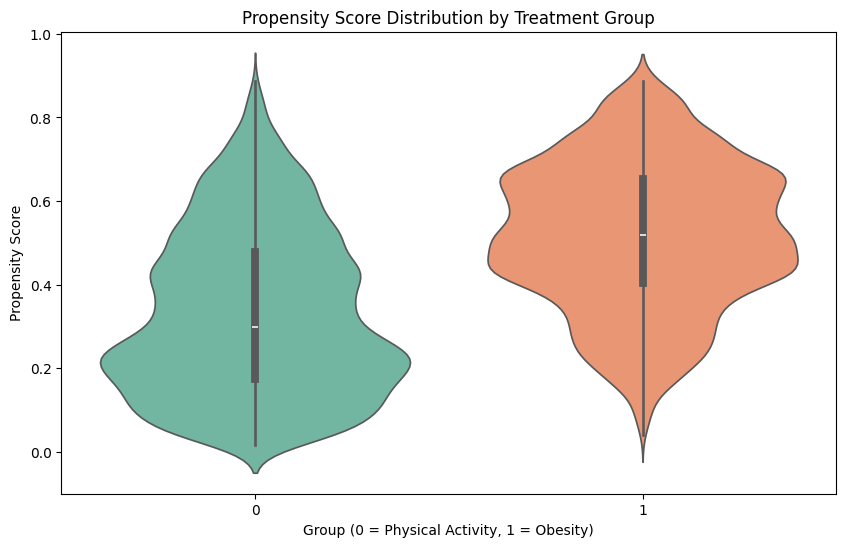

In [6]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Treatment', y='Propensity_Score', data=combined_df, palette="Set2")
plt.title('Propensity Score Distribution by Treatment Group')
plt.xlabel('Group (0 = Physical Activity, 1 = Obesity)')
plt.ylabel('Propensity Score')
plt.show()


Causal Forest

WIP